# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_year_date_str_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260107.xlsx"
code = "7011"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
date_str = get_year_date_str_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/0107
パラメータ
PERIOD_MA_1 : 60
PERIOD_MA_2 : 900
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.08
LOSSCUT_1 : -25


In [3]:
# 取引明細
df_transaction = app.getTransaction()
print("取引明細")
list_html = conv_transaction_df2html(df_transaction)
filename = os.path.join("output", f"{date_str}_{code}_transaction.html")
print(filename)
with open(filename, mode="w") as f:
    f.write("\n".join(list_html))

print(df_transaction)
list_trans = [pd.to_datetime(t) for t in df_transaction["注文日時"]]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
output/2026/0107_7011_transaction.html
   注文番号                 注文日時 銘柄コード  売買  約定単価 約定数量     損益 備考
0     1  2026-01-07 09:03:46  7011  売建  4195  100    NaN   
1     2  2026-01-07 09:11:23  7011  買埋  4200  100   -500   
2     3  2026-01-07 09:11:24  7011  買建  4200  100    NaN   
3     4  2026-01-07 09:12:53  7011  売埋  4189  100  -1100   
4     5  2026-01-07 09:12:54  7011  売建  4190  100    NaN   
5     6  2026-01-07 09:17:42  7011  買埋  4193  100   -300   
6     7  2026-01-07 09:20:00  7011  売建  4185  100    NaN   
7     8  2026-01-07 09:20:41  7011  買埋  4192  100   -700   
8     9  2026-01-07 09:20:42  7011  買建  4192  100    NaN   
9    10  2026-01-07 09:34:41  7011  売埋  4196  100    400   
10   11  2026-01-07 09:40:07  7011  買建  4200  100    NaN   
11   12  2026-01-07 09:40:40  7011  売埋  4198  100   -200   
12   13  2026-01-07 09:42:33  7011  買建  4201  100    NaN   
13   14  2026-01-07 09:50:21  7011  売埋  4199  100   -200   
14   15  2026-01-07 10:25:05  7011  売建  4213  100    NaN

In [4]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts          ma1          ma2    slope1  profit  \
2026-01-07 09:00:01  1.767744e+09  4193.000000  4193.000000  0.000000     0.0   
2026-01-07 09:00:02  1.767744e+09  4193.000000  4193.000000  0.000000     0.0   
2026-01-07 09:00:03  1.767744e+09  4193.333333  4193.333333  0.200000     0.0   
2026-01-07 09:00:04  1.767744e+09  4193.500000  4193.500000  0.190476     0.0   
2026-01-07 09:00:05  1.767744e+09  4194.800000  4194.800000  0.561111     0.0   
...                           ...          ...          ...       ...     ...   
2026-01-07 15:24:45  1.767767e+09  4157.333333  4154.243333  0.072778     0.0   
2026-01-07 15:24:46  1.767767e+09  4157.400000  4154.258889  0.068889     0.0   
2026-01-07 15:24:47  1.767767e+09  4157.466667  4154.274444  0.066667     0.0   
2026-01-07 15:24:48  1.767767e+09  4157.550000  4154.291111  0.072222     0.0   
2026-01-07 15:24:49  1.767767e+09  4157.633333  4154.307778  0.077222     0.0   

                   

In [5]:
df_tech["slope1"].describe()

count    19429.000000
mean        -0.001819
std          0.063225
min         -0.416667
25%         -0.033333
50%          0.000000
75%          0.024444
max          1.894603
Name: slope1, dtype: float64

In [6]:
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

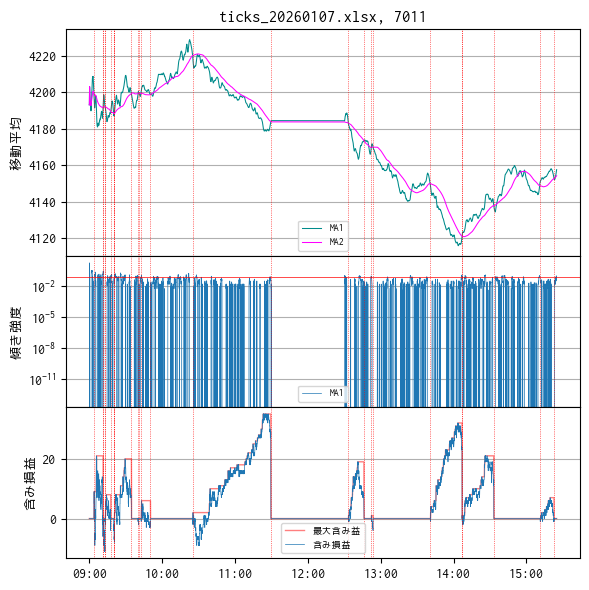

In [7]:
fig = plt.figure(figsize=(6, 6))
n = 3
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[1.5 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["ma1"], linewidth=0.75, color="darkcyan", label="MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5)
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)

ax[2].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[2].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[2].set_ylabel("含み損益")
ax[2].legend(fontsize=7)

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
#output = os.path.join("output", f"{date_str}_{code}_trend_technical.png")
output = os.path.join("tmp", f"{date_str}_{code}_trend_technical.png")
plt.tight_layout()
plt.savefig(output)
plt.show()

In [8]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  ロス1   建玉
2026-01-07 09:00:01    0.0    0.0  0.0  0.0  0.0
2026-01-07 09:00:02    0.0    0.0  0.0  0.0  0.0
2026-01-07 09:00:03    0.0    0.0  0.0  0.0  0.0
2026-01-07 09:00:04    0.0    0.0  0.0  0.0  0.0
2026-01-07 09:00:05    0.0    0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...
2026-01-07 15:24:45    0.0    0.0  0.0  0.0  0.0
2026-01-07 15:24:46    0.0    0.0  0.0  0.0  0.0
2026-01-07 15:24:47    0.0    0.0  0.0  0.0  0.0
2026-01-07 15:24:48    0.0    0.0  0.0  0.0  0.0
2026-01-07 15:24:49    0.0    0.0  0.0  0.0  0.0

[19429 rows x 5 columns]


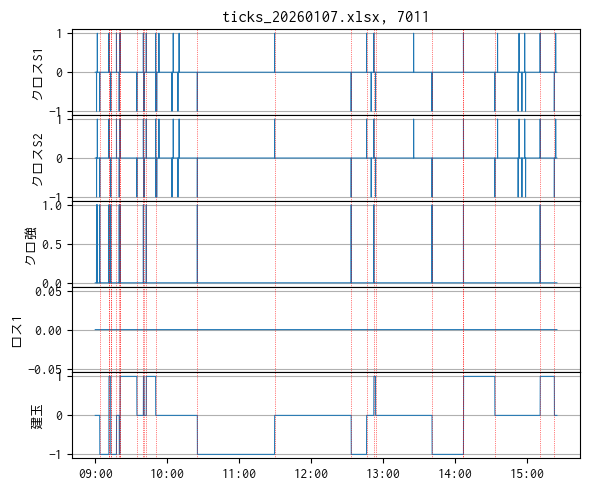

In [9]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=[1 for i in range(n)])
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

for i, colname in enumerate(df_obs.columns):
    ax[i].plot(df_obs[colname], linewidth=0.75)
    ax[i].set_ylabel(colname)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
#output = os.path.join("output", f"{date_str}_{code}_trend_obs.png")
output = os.path.join("tmp", f"{date_str}_{code}_trend_obs.png")
plt.tight_layout()
plt.savefig(output)
plt.show()